In [1]:
import sys
sys.argv = ['']

In [2]:
#from diffuser.utils.arrays import to_torch, to_np, to_device
#from diffuser.datasets.d4rl import suppress_output
#from scripts.buffer_utils import LoadSequenceDataset
#from scripts.buffer_utils import OptimalBuffer
from scripts.mopo.utils_trans import RewardPredictingModel 
#from scripts.buffer_utils import augment_trajectories_new
import diffuser.utils as utils

/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import shutil 
import argparse 
import time 
import pickle
import sys
import os
import torch
import random
import importlib
from collections import defaultdict
import pdb
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from time import time

In [5]:
from collections import defaultdict

In [6]:
from sklearn.cluster import KMeans

In [7]:
import d4rl

No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11


In [8]:
def import_config(config_name):
    module_path = f"detail_configs.{config_name}"
    try:
        module = importlib.import_module(module_path)
        return module.Config    
    except ImportError:
        print(f"Error: Module '{config_name}' not found or has no 'Config' attribute.")
        return None

In [9]:
from ml_logger import logger

Config = import_config('kitchen_partial_task')

Config.dataset = 'kitchen-partial-v0'

In [ ]:
# log path
BASE_WEIGHTS_PATH = os.path.join(Config.bucket, Config.dataset)
save_config_path = os.path.join(BASE_WEIGHTS_PATH, "config")
logger.configure(save_config_path)
torch.backends.cudnn.benchmark = True

# training dataset for Diffuser
dataset_config = utils.Config(
		'datasets.CondSequenceDataset',
		savepath='dataset_config.pkl',
		env=Config.dataset,
		horizon=Config.horizon,
		normalizer=Config.normalizer,
		preprocess_fns=Config.preprocess_fns,
		use_padding=Config.use_padding,
		max_path_length=Config.max_path_length,
		include_returns=Config.include_returns,
		returns_scale=Config.returns_scale,
        data_file=Config.data_file,
	)
render_config = utils.Config(
        Config.renderer,
        savepath="render_config.pkl",
        env=Config.dataset,
    )

dataset = dataset_config()
renderer = None
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
loadpath = os.path.join(Config.bucket, Config.dataset, Config.prefix, 'checkpoint')
print('\n\nloadpath = ', loadpath, end = '\n\n')



# model configs
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
transition_dim = observation_dim

model_config = utils.Config(
		Config.model,
		savepath='model_config.pkl',
		horizon=Config.horizon,
		transition_dim=transition_dim,
		cond_dim=observation_dim,
		dim_mults=Config.dim_mults,
		dim=Config.dim,
		returns_condition=Config.returns_condition,
		device=Config.device,
	)

diffusion_config = utils.Config(
    Config.diffusion,
    savepath='diffusion_config.pkl',
    horizon=Config.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=Config.n_diffusion_steps,
    loss_type=Config.loss_type,
    clip_denoised=Config.clip_denoised,
    predict_epsilon=Config.predict_epsilon,
    hidden_dim=Config.hidden_dim,
    ## loss weighting
    action_weight=Config.action_weight,
    loss_weights=Config.loss_weights,
    loss_discount=Config.loss_discount,
    returns_condition=Config.returns_condition,
    device=Config.device,
    condition_guidance_w=Config.condition_guidance_w,
)

trainer_config = utils.Config(
		utils.Trainer,
		savepath='trainer_config.pkl',
		train_batch_size=Config.batch_size,
		train_lr=Config.learning_rate,
		gradient_accumulate_every=Config.gradient_accumulate_every,
		ema_decay=Config.ema_decay,
		sample_freq=Config.sample_freq,
		save_freq=Config.save_freq,
		log_freq=Config.log_freq,
		label_freq=int(Config.n_train_steps // Config.n_saves),
		save_parallel=Config.save_parallel,
		bucket=Config.bucket,
		n_reference=Config.n_reference,
        n_samples=Config.n_samples,
		train_device=Config.device,
	)
model = model_config()
diffusion = diffusion_config(model)
trainer = trainer_config(diffusion, dataset, renderer)

# load Diffuser model
loadpath = os.path.join(loadpath, f'state_1000000.pt')
state_dict = torch.load(loadpath, map_location=Config.device)
trainer.step = state_dict['step']
trainer.model.load_state_dict(state_dict['model'])
trainer.ema_model.load_state_dict(state_dict['ema'])

# load Dynamic model
Config.dynamic_model_path = '/common/users/cc1547/projects/rainbow/diffstitch/dynamic/kitchen-partial-v0/mopo/' \
'seed_1_0807_170549-kitchen_partial_v0_mopo/models/ite_dynamics_model'
dynamics_model = RewardPredictingModel(
    device = Config.device, 
    env_name = Config.dataset, 
    load_path = Config.dynamic_model_path
) 

✓ created a new logging client
Dashboard: http://app.dash.ml/common/users/cc1547/projects/rainbow/diffstitch/diffuser/kitchen-partial-v0/config
Log_directory: /common/home/cc1547/projects/diff_stitch
[ utils/config ] Imported diffuser.datasets:CondSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CondSequenceDataset'>
    data_file: None
    env: kitchen-partial-v0
    horizon: 40
    include_returns: True
    max_path_length: 280
    normalizer: CDFNormalizer
    preprocess_fns: []
    returns_scale: 1.0
    use_padding: True

[ utils/config ] Saved config to: dataset_config.pkl

[ utils/config ] Imported diffuser.utils:MuJoCoRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.MuJoCoRenderer'>
    env: kitchen-partial-v0

[ utils/config ] Saved config to: render_config.pkl

class =  <class 'diffuser.datasets.sequence.CondSequenceDataset'>
kwargs =  {}


No module named 'flow'
/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:51:11
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 30.77it/s]


[ datasets/buffer ] Finalized replay buffer | 613 episodes
[ datasets/buffer ] Fields:
    observations: (613, 280, 30)
    rewards: (613, 280, 1)
    actions: (613, 280, 9)
    terminals: (613, 280, 1)
    normed_observations: (613, 280, 30)
    normed_actions: (613, 280, 9)


loadpath =  /common/users/cc1547/projects/rainbow/diffstitch/diffuser/kitchen-partial-v0/default_inv/predict_epsilon_100_1000000.0/dropout_0.25/kitchen_partial/task/40/checkpoint

[ utils/config ] Imported diffuser.models:TemporalUnet

[utils/config ] Config: <class 'diffuser.models.temporal.TemporalUnet'>
    cond_dim: 30
    dim: 128
    dim_mults: (1, 4, 8)
    horizon: 40
    returns_condition: True
    transition_dim: 30

[ utils/config ] Saved config to: model_config.pkl

[ utils/config ] Imported diffuser.models:GaussianInvDynDiffusion

[utils/config ] Config: <class 'diffuser.models.diffusion.GaussianInvDynDiffusion'>
    action_dim: 9
    action_weight: 10
    clip_denoised: True
    condition_guidance_

In [10]:
def to_np(x):
    if torch.is_tensor(x):
        x = x.detach().cpu().numpy()
    return x


def to_torch(x, dtype=None, device=None):
    dtype = dtype or DTYPE
    device = device or DEVICE
    if type(x) is dict:
        return {k: to_torch(v, dtype, device) for k, v in x.items()}
    elif torch.is_tensor(x):
        return x.to(device).type(dtype)
        # import pdb; pdb.set_trace()
    return torch.tensor(x, dtype=dtype, device=device)


def to_device(x, device=Config.device):
    if torch.is_tensor(x):
        return x.to(device)
    elif type(x) is dict:
        return {k: to_device(v, device) for k, v in x.items()}
    else:
        print(f"Unrecognized type in `to_device`: {type(x)}")
        pdb.set_trace()
    # return [x.to(device) for x in xs]

In [11]:
def process_kitchen_episode(episode):
    rewards_ = episode["rew"][1:] - episode["rew"][:-1]
    rewards = np.concatenate([episode["rew"][:1], rewards_], axis=0)
    episode["rew"] = rewards

    obs = episode["obs"]
    episode["obs"] = obs[:, :30]  # remove the goal
    next_obs = episode["next_obs"]
    episode['next_obs'] = next_obs[:, :30]
    return episode

def task_dataset(seq_dataset):

    tasks = []

    task_data = defaultdict(list)
    rewards = seq_dataset["rew"]

    l = rewards.shape[0]
    for i in range(l):

        for k in seq_dataset:
            task_data[k].append(seq_dataset[k][i])

        if rewards[i] == 1:
            for k in task_data:
                task_data[k] = np.array(task_data[k])
            tasks.append(task_data)
            task_data = defaultdict(list)

    '''
    if len(task_data) > 0:
        for k in task_data:
            task_data[k] = np.array(task_data[k])
        tasks.append(task_data)
    '''
    return tasks

In [12]:
def load_data(data_file):
    with open(data_file, "rb") as fp:
        ds = pickle.load(fp)
    return ds
    
class LoadSequenceDataset:
    def __init__(self, env_name, data_file):
        if 'kitchen' not in env_name:
            dataset = load_data(data_file)
            if "AntMaze_UMaze-v4" in env_name:
                dataset_name = "antmaze-umaze-v0"
            elif "AntMaze_Medium-v4" in env_name:
                dataset_name = "antmaze-medium-v0"
            elif "AntMaze_Large-v4" in env_name:
                dataset_name = "antmaze-large-v0"
            elif "PointMaze_UMaze-v3" in env_name:
                dataset_name = "pointmaze-umaze-v0"
            elif "PointMaze_Medium-v3" in env_name:
                dataset_name = "pointmaze-medium-v1"
            elif "PointMaze_Large-v3" in env_name:
                dataset_name = "pointmaze-large-v1"
            else:
                raise NotImplementedError
            max_path_length = 600
        else:
            env = gym.make(env_name)
            dataset = env.get_dataset()
            max_path_length = 280

        print(f"\nnumber of offline data is {dataset['rewards'].shape[0]}\n")

        paths = []
        current_path = {"obs": [], "act": [], "rew": [], "dones": [], "next_obs": []}
        
        use_timeouts = "timeouts" in dataset

        print(use_timeouts)

        for i in range(dataset["rewards"].shape[0] - 1):
            if 'kitchen' not in env_name:
                current_path["obs"].append(dataset["observations"]["observation"][i])
                current_path["dones"].append(dataset["terminations"][i])
                current_path["next_obs"].append(
                dataset["observations"]["observation"][i + 1]
            )
            else:
                current_path['obs'].append(dataset['observations'][i])
                current_path["dones"].append(dataset["terminals"][i])
                current_path["next_obs"].append(
                dataset["observations"][i + 1]
            )
                
            current_path["act"].append(dataset["actions"][i])
            current_path["rew"].append(dataset["rewards"][i])
            
            

            if use_timeouts:
                final_timestep = dataset["timeouts"][i]
            else:
                final_timestep = len(current_path["obs"]) == max_path_length

            done = dataset['terminations'][i] if 'kitchen' not in env_name else dataset['terminals'][i]
            if bool(done) or final_timestep:
                for _ in current_path:
                    current_path[_] = np.array(current_path[_])
                if 'kitchen' in env_name:
                    current_path = process_kitchen_episode(current_path)
                    task_path = task_dataset(current_path)
                    paths.extend(task_path)
                else:
                    paths.append(current_path)
                current_path = {
                    "obs": [],
                    "act": [],
                    "rew": [],
                    "dones": [],
                    "next_obs": [],
                }
        self.paths = paths
        self.num_traj = len(self.paths)

    def get_full_info_traj(self, idx, gamma=0.99):
        obs = []
        act = []
        rew = []
        next_obs = []
        dones = []
        region_idx = []
        obs = np.copy(self.paths[idx]["obs"])
        act = np.copy(self.paths[idx]["act"])
        rew = np.copy(self.paths[idx]["rew"])
        next_obs = np.copy(self.paths[idx]["next_obs"])
        dones = np.copy(self.paths[idx]["dones"])

        total_return = np.sum(rew)
        discounted_return = 0
        for i in range(rew.shape[0] - 1, -1, -1):
            discounted_return = discounted_return * gamma + rew[i]
        return {
            "obs": obs,
            "act": act,
            "rew": rew,
            "next_obs": next_obs,
            "dones": dones,
            "total_return": total_return,
            "discounted_return": discounted_return,
            "horizon": rew.shape[0],
            "trajectory_idx": idx,
        }

In [13]:
class OptimalBuffer:
    def __init__(self, horizon, ratio=0.1, gamma=0.99):
        self.gamma = gamma
        self.ratio = ratio
        self.info = []
        self.horizon = horizon
        self.region_map = defaultdict(list)
        self.returns_list = []

    def insert_traj(self, info):
        current_total_reward = 0
        current_discounted_reward = 0
        for i in range(info["horizon"] - 1, -1, -1):
            current_total_reward += info["rew"][i]
            current_discounted_reward = (
                current_discounted_reward * self.gamma + info["rew"][i]
            )
            if info["horizon"] - i >= self.horizon:
                current_info = {
                    "discounted_reward": current_discounted_reward,
                    "obs": info["obs"][i : i + self.horizon],
                    "segment_idx": i,
                    "traj_idx": info["trajectory_idx"],
                    'rew': info['rew'][i: i+self.horizon],
                }
                self.info.append(current_info)
    
    def finalize(self, ):
        num_seg = len(self.info)
        all_obs = np.array([info['obs'] for info in self.info]).mean(axis=-1)
        kmeans = KMeans(n_clusters=10, n_init='auto').fit(all_obs)
        labels = kmeans.labels_
        for i in range(num_seg):
            self.info[i]['region_idx'] = np.ones(self.horizon,dtype=np.int32) * labels[i]
            self.region_map[labels[i]+1].append(i)
            self.returns_list.append(sum(self.info[i]['rew']))
        self.returns_list = np.array(self.returns_list)
        self.returns_list -= self.returns_list.min()

    def sample_batch_traj(self, optim_batch, dataset, region_avoid):
        # stored in (d-rtg, obs:(100, obs_dim))

        sample_idx = []
        
        for k in self.region_map:
            if k not in region_avoid:
                sample_idx += self.region_map[k]

        sample_p = self.returns_list[np.array(sample_idx)]
        sample_p = sample_p / sample_p.sum()
        batch_info = []
        batch_index = np.random.choice(sample_idx, size=optim_batch, replace=False, p=sample_p)
        batch_info = [self.info[_] for _ in batch_index]

        return batch_info

In [14]:
# prepare dataset for stitching
env_name = Config.dataset
if 'kitchen' in env_name:
    data_file = None
else:
    if "AntMaze_UMaze-v4" in env_name:
        dataset_name = "antmaze-umaze-v0"
    elif "AntMaze_Medium-v4" in env_name:
        dataset_name = "antmaze-medium-v0"
    elif "AntMaze_Large-v4" in env_name:
        dataset_name = "antmaze-large-v0"
    elif "PointMaze_UMaze-v3" in env_name:
        dataset_name = "pointmaze-umaze-v1"
    elif "PointMaze_Medium-v3" in env_name:
        dataset_name = "pointmaze-medium-v1"
    elif "PointMaze_Large-v3" in env_name:
        dataset_name = "pointmaze-large-v1"
    
    dataset_name = dataset_name + ".pkl"
    data_file = Config.data_file + dataset_name
env_dataset = LoadSequenceDataset(env_name = Config.dataset, data_file=data_file)
data_buffer  = OptimalBuffer(horizon=Config.horizon)
for i in range(env_dataset.num_traj): 
    info = env_dataset.get_full_info_traj(i)  
    data_buffer.insert_traj(info) 
data_buffer.finalize()

Reading configurations for Franka
Initializing Franka sim


/common/home/cc1547/miniconda3/envs/diffstitch/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.01it/s]



number of offline data is 136950

True


## Start stitching

In [15]:
# helper functions
#def cosine_similarity(x, y):
#    x_norm = np.linalg.norm(x)
#    y_norm = np.linalg.norm(y, axis=1)
#    dot_product = np.dot(y, x)
#    similarity = dot_product / (x_norm * y_norm)
#    return similarity

def cosine_similarity(x, y):
    x_norm = np.linalg.norm(x, axis=1, keepdims=True)
    y_norm = np.linalg.norm(y, axis=1, keepdims=True)
    similarity = np.dot(x/x_norm, (y/y_norm).transpose())
    return similarity

def comp_distance(x, y):
    return np.linalg.norm(x-y, axis=-1)

def cell_xy_to_rowcol(maze, xy_pos: np.ndarray) -> np.ndarray:
    """Converts a cell x and y coordinates to `(i,j)`"""

    i = np.reshape((maze.y_map_center - xy_pos[:, 1]) / maze.maze_size_scaling, (-1, 1))
    j = np.reshape((xy_pos[:, 0] + maze.x_map_center) / maze.maze_size_scaling, (-1, 1))

    return np.concatenate([i,j], axis=-1)

In [16]:
class Timer:
    def __init__(self):
        self.total_clapsed = 0
        self.start = time()
        self.call_time = 0

    def __call__(self):
        
        clapsed = time() - self.start
        self.call_time += 1
        
        self.total_clapsed += clapsed
        self.start = time()
        return self.total_clapsed

    def mean(self,):
        
        clapsed = time() - self.start
        self.call_time += 1
        
        self.total_clapsed += clapsed
        self.start = time()
        return self.total_clapsed / self.call_time
        

In [17]:
def get_conditions(conditions, start, x, device):

    obs_dim = x.shape[-1]
    
    conditions[:, :, obs_dim:] = 0
    conditions[:, :start, :obs_dim] = 0
    conditions[:, :start, obs_dim:] = x[:, -start:, :]
    conditions = torch.tensor(conditions).to(device)
    
    return conditions

In [18]:
horizon = Config.horizon
device = Config.device
dynamics_deviate = 0.15
test_ret = 0.85
sample_optim_batch = 1000
dreamer_similarity = 0.95
stitch_L = 10
stitch_R = 30
#obs_dim = observation_dim
dream_len = Config.dream_len
stitch_batch_size = 1000

### Second round stitch

In [97]:
with open('./round1_stitch_point_medium.pkl', 'rb') as f:
    stitched_data = pickle.load(f)

In [30]:
class StitchDataset:
    def __init__(self, trajectories):
        self.paths = trajectories
        self.num_traj = len(self.paths)
        print(f'processed {self.num_traj} trajectories')

    def get_full_info_traj(self, idx, gamma=0.99):
        obs = []
        act = []
        rew = []
        next_obs = []
        dones = []
        region_idx = []
        obs = np.copy(self.paths[idx]["obs"])
        act = np.copy(self.paths[idx]["act"])
        rew = np.copy(self.paths[idx]["rew"])
        next_obs = np.copy(self.paths[idx]["next_obs"])
        dones = np.copy(self.paths[idx]["dones"])
        region_idx = np.copy(self.paths[idx]["region_idx"])

        total_return = np.sum(rew)
        discounted_return = 0
        for i in range(rew.shape[0] - 1, -1, -1):
            discounted_return = discounted_return * gamma + rew[i]
        return {
            "obs": obs,
            "act": act,
            "rew": rew,
            "next_obs": next_obs,
            "dones": dones,
            "total_return": total_return,
            "discounted_return": discounted_return,
            "horizon": rew.shape[0],
            "region_idx": region_idx,
            "trajectory_idx": idx,
        }

In [29]:
def process_stitched_trajectories(origin_trj1, stitch_trj, origin_trj2):
    """ concatenate one origin_trj and the corresponding stitch_trj"""
    
    keys = ['obs', 'act', 'rew', 'next_obs', 'dones']
    new_trj = {}
    for k in keys:
        assert k in origin_trj1, f'{k} not in origin_trj1'
        assert k in origin_trj2, f'{k} not in origin_trj2'
        assert k in stitch_trj, f'{k} not in stitch_trj'
        new_trj[k] = np.concatenate([origin_trj1[k], stitch_trj[k], origin_trj2[k]], axis=0)
        
    trj_len = new_trj['obs'].shape[0]
    new_trj['region_idx'] = stitch_trj['region_idx']
    return new_trj

In [28]:
def read_stitched_data(aug_list, trj1_dataset):
    stitched_trjs = []
    for i in range(len(aug_list)):
        
        stitch_trj = dict(
            obs = aug_list[i][7][1:],
            act = aug_list[i][8][1:],
            rew = aug_list[i][9][1:],
            next_obs = aug_list[i][10][1:],
            dones = aug_list[i][11][1:],
            region_idx = aug_list[i][12],
        )# the first state in stitch is the last state in trj1
    
        traj2_idx = aug_list[i][2]
        traj2_segment_idx = aug_list[i][3]
        trj2 = env_dataset.get_full_info_traj(traj2_idx)
        for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
            trj2[k] = trj2[k][traj2_segment_idx:]
    
        traj1_idx = aug_list[i][0]
        traj1_segment_idx = aug_list[i][1]
        trj1 = trj1_dataset.get_full_info_traj(traj1_idx)
        for k in ['obs', 'act', 'rew', 'next_obs', 'dones']:
            trj1[k] = trj1[k][:traj1_segment_idx+horizon] 
    
        new_trj = process_stitched_trajectories(trj1, stitch_trj, trj2)
        stitched_trjs.append(new_trj)
    return stitched_trjs

In [22]:
with open('./round1_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_1 = pickle.load(f)

with open('./round2_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_2 = pickle.load(f)

with open('./round3_stitch_kitchen_partial_H40.pkl', 'rb') as f:
    aug_list_3 = pickle.load(f)

In [23]:
stitch_1 = read_stitched_data(aug_list_1, env_dataset)
stitch_1_dataset = StitchDataset(stitch_1)
stitch_2 = read_stitched_data(aug_list_2, stitch_1_dataset)
stitch_2_dataset = StitchDataset(stitch_2)
stitch_3 = read_stitched_data(aug_list_3, stitch_2_dataset)

processed 1297 trajectories
processed 1657 trajectories


In [27]:
def post_process_stitched_trjs(stitched_trjs):
    for trj in stitched_trjs:
        trj['dones'][-1] = True
    
    post_process_stitch = defaultdict(list)
    for trj in stitched_trjs:
        post_process_stitch['actions'].extend(trj['act'])
        post_process_stitch['observations'].extend(trj['obs'])
        post_process_stitch['terminals'].extend(trj['dones'])
        post_process_stitch['rewards'].extend(trj['rew'])
    for k in post_process_stitch:

        post_process_stitch[k] = np.array(post_process_stitch[k])
    return post_process_stitch

In [25]:
post_processed_stitch1 = post_process_stitched_trjs(stitch_1)
post_processed_stitch2 = post_process_stitched_trjs(stitch_2)
post_processed_stitch3 = post_process_stitched_trjs(stitch_3)

In [26]:
for k in post_processed_stitch1:
    print(f'{k} shape: {post_processed_stitch1[k].shape}')

actions shape: (200623, 9)
observations shape: (200623, 30)
terminals shape: (200623,)
rewards shape: (200623,)


In [27]:
for k in post_processed_stitch2:
    print(f'{k} shape: {post_processed_stitch2[k].shape}')

actions shape: (272682, 9)
observations shape: (272682, 30)
terminals shape: (272682,)
rewards shape: (272682,)


In [28]:
for k in post_processed_stitch3:
    print(f'{k} shape: {post_processed_stitch3[k].shape}')

actions shape: (284499, 9)
observations shape: (284499, 30)
terminals shape: (284499,)
rewards shape: (284499,)


In [249]:
file1_name = './round1_stitch_kitchen_partial_H40-v1.pkl'
file2_name = './round2_stitch_kitchen_partial_H40-v1.pkl'
file3_name = './round3_stitch_kitchen_partial_H40-v1.pkl'

In [251]:
with open(file1_name, 'wb') as f:
    pickle.dump(post_processed_stitch1, f)

with open(file2_name, 'wb') as f:
    pickle.dump(post_processed_stitch2, f)

with open(file3_name, 'wb') as f:
    pickle.dump(post_processed_stitch3, f)

[139 115 102 ... 172 185 138]
total_trans: 200623 154.6823438704703 93 259


(array([ 12.,  76., 118., 119.,  80.,  94., 116., 109., 105.,  99.,  88.,
        103.,  93.,  39.,  23.,   8.,   5.,   4.,   2.,   4.]),
 array([ 93. , 101.3, 109.6, 117.9, 126.2, 134.5, 142.8, 151.1, 159.4,
        167.7, 176. , 184.3, 192.6, 200.9, 209.2, 217.5, 225.8, 234.1,
        242.4, 250.7, 259. ]),
 <BarContainer object of 20 artists>)

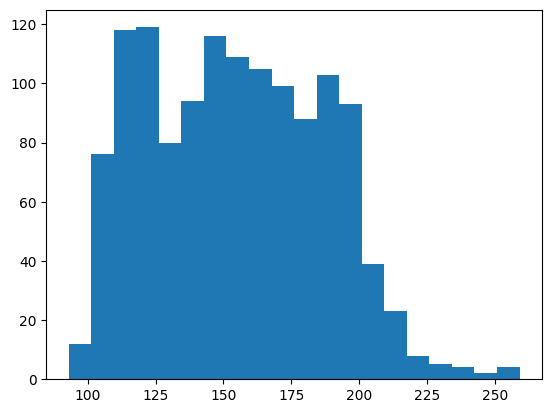

In [71]:
trans_len1 = np.array([trj['obs'].shape[0] for trj in stitch_1])
print(trans_len1)
total_trans = np.sum(trans_len1)
print(f'total_trans: {total_trans}', np.mean(trans_len1), np.min(trans_len1), np.max(trans_len1))
plt.hist(trans_len1, bins=20)

[105 154 113 ... 292 146 220]
total_trans: 272682 164.56366928183465 90 312


(array([  9.,  92., 153., 133., 122., 170., 182., 185., 196., 185., 102.,
         62.,  36.,  17.,   7.,   3.,   1.,   1.,   0.,   1.]),
 array([ 90. , 101.1, 112.2, 123.3, 134.4, 145.5, 156.6, 167.7, 178.8,
        189.9, 201. , 212.1, 223.2, 234.3, 245.4, 256.5, 267.6, 278.7,
        289.8, 300.9, 312. ]),
 <BarContainer object of 20 artists>)

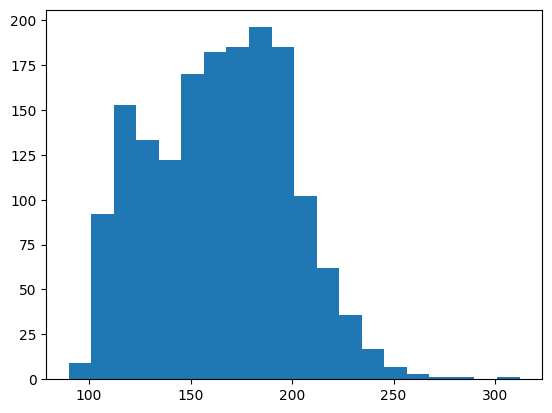

In [257]:
trans_len2 = np.array([trj['obs'].shape[0] for trj in stitch_2])
print(trans_len)
total_trans = np.sum(trans_len2)
print(f'total_trans: {total_trans}', np.mean(trans_len2), np.min(trans_len2), np.max(trans_len2))
plt.hist(trans_len2, bins=20)

[105 154 113 ... 292 146 220]
total_trans: 284499 172.3192004845548 93 294


(array([ 17.,  76., 122.,  97., 100.,  94., 157., 166., 147., 188., 168.,
        107.,  71.,  49.,  36.,  27.,  13.,  11.,   2.,   3.]),
 array([ 93.  , 103.05, 113.1 , 123.15, 133.2 , 143.25, 153.3 , 163.35,
        173.4 , 183.45, 193.5 , 203.55, 213.6 , 223.65, 233.7 , 243.75,
        253.8 , 263.85, 273.9 , 283.95, 294.  ]),
 <BarContainer object of 20 artists>)

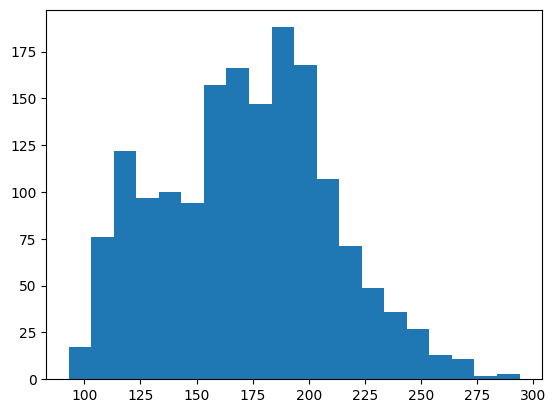

In [219]:
trans_len3 = np.array([trj['obs'].shape[0] for trj in stitch_3])
print(trans_len)
total_trans = np.sum(trans_len3)
print(f'total_trans: {total_trans}', np.mean(trans_len3), np.min(trans_len3), np.max(trans_len3))
plt.hist(trans_len3, bins=20)

In [164]:
stitched_trjs[0].keys()

dict_keys(['obs', 'act', 'rew', 'next_obs', 'dones', 'region_idx'])

In [ ]:
stti

In [64]:
stitch_1_rew = np.array([sum(trj['rew']) for trj in stitch_1])
print(f'stitch1 rew: max: {np.max(stitch_1_rew)}\t mean: {np.mean(stitch_1_rew)}\t min: {np.min(stitch_1_rew)}')

stitch_2_rew = np.array([sum(trj['rew']) for trj in stitch_2])
print(f'stitch1 rew: max: {np.max(stitch_2_rew)}\t mean: {np.mean(stitch_2_rew)}\t min: {np.min(stitch_2_rew)}')

stitch_3_rew = np.array([sum(trj['rew']) for trj in stitch_3])
print(f'stitch1 rew: max: {np.max(stitch_3_rew)}\t mean: {np.mean(stitch_3_rew)}\t min: {np.min(stitch_3_rew)}')

stitch1 rew: max: 2.0	 mean: 0.69236700077101	 min: -1.0
stitch1 rew: max: 2.0	 mean: 0.7006638503319251	 min: -1.0
stitch1 rew: max: 2.0	 mean: 0.7813446396123561	 min: -1.0


(array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 2., 3., 1., 2., 2.,
        0., 0., 1.]),
 array([106.  , 110.25, 114.5 , 118.75, 123.  , 127.25, 131.5 , 135.75,
        140.  , 144.25, 148.5 , 152.75, 157.  , 161.25, 165.5 , 169.75,
        174.  , 178.25, 182.5 , 186.75, 191.  ]),
 <BarContainer object of 20 artists>)

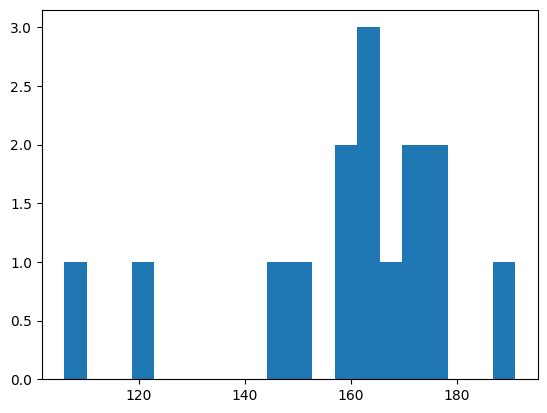

In [230]:
plt.hist(trans_len1[np.where(stitch_1_rew==2)[0]], bins=20)

(array([1., 2., 0., 2., 4., 7., 4., 6., 9., 3., 4., 5., 2., 1., 0., 2., 2.,
        1., 2., 2.]),
 array([116. , 122.4, 128.8, 135.2, 141.6, 148. , 154.4, 160.8, 167.2,
        173.6, 180. , 186.4, 192.8, 199.2, 205.6, 212. , 218.4, 224.8,
        231.2, 237.6, 244. ]),
 <BarContainer object of 20 artists>)

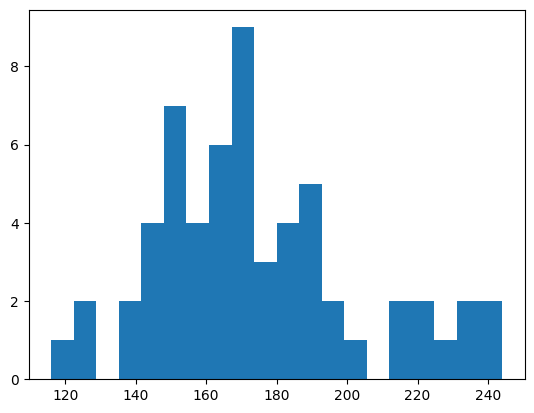

In [229]:
plt.hist(trans_len2[np.where(stitch_2_rew==2)[0]], bins=20)

(array([ 4.,  2.,  3.,  4.,  8.,  9., 21., 15., 22., 17., 13., 14.,  9.,
         3., 10.,  5.,  4.,  0.,  0.,  2.]),
 array([108. , 115.9, 123.8, 131.7, 139.6, 147.5, 155.4, 163.3, 171.2,
        179.1, 187. , 194.9, 202.8, 210.7, 218.6, 226.5, 234.4, 242.3,
        250.2, 258.1, 266. ]),
 <BarContainer object of 20 artists>)

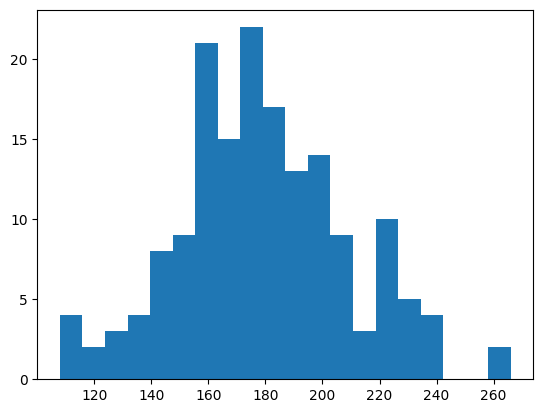

In [228]:
plt.hist(trans_len3[np.where(stitch_3_rew==2)[0]], bins=20)

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

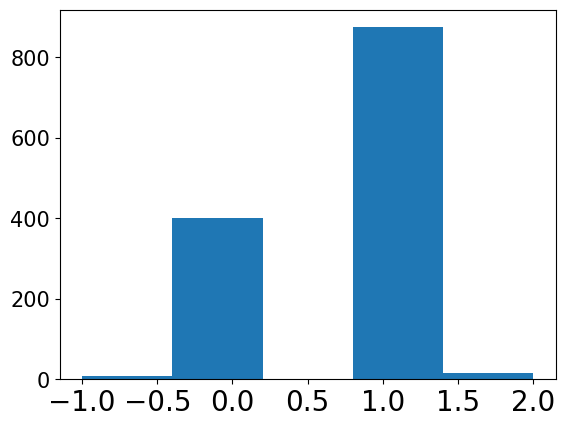

In [65]:
plt.hist(stitch_1_rew, bins=5)
plt.xticks(size = 20)
plt.yticks(size = 15)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

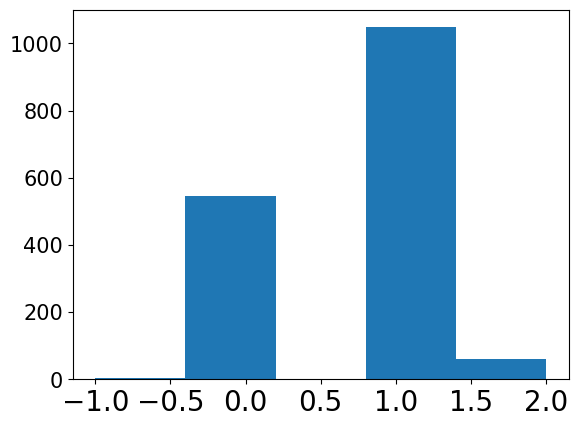

In [40]:
plt.hist(stitch_2_rew, bins=5)
plt.xticks(size = 20)
plt.yticks(size = 15)

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

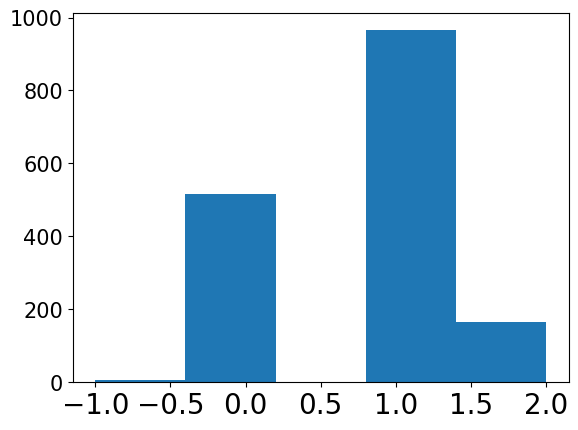

In [41]:
plt.hist(stitch_3_rew, bins=5)
plt.xticks(size = 20)
plt.yticks(size = 15)

In [47]:
def comp_epi_return(dataset, discount=0.99):
    discounts = discount ** np.arange(1000)
    r = []
    for seq in dataset:
        rewards = seq['rew']
        
        r_ = 0
        l = len(rewards)
        
        for i in range(l):
            r_ = (discounts[:l-i] * rewards[i:]).sum()
            r.append(r_)
        
    return r

In [59]:
round1_return = np.array(comp_epi_return(stitch_1))
round2_return = np.array(comp_epi_return(stitch_2))
round3_return = np.array(comp_epi_return(stitch_3))
print(f'traj1 return: max: {np.max(round1_return)}\t, mean: {np.mean(round1_return)}\t min: {np.min(round1_return)}')
print(f'traj2 return: max: {np.max(round2_return)}\t, mean: {np.mean(round2_return)}\t min: {np.min(round2_return)}')
print(f'traj3 return: max: {np.max(round3_return)}\t, mean: {np.mean(round3_return)}\t min: {np.min(round3_return)}')

traj1 return: max: 1.5639051904523875	, mean: 0.3337770893115084	 min: -1.0
traj2 return: max: 1.5048858887870695	, mean: 0.31586901793176153	 min: -1.0
traj3 return: max: 1.5526834771623852	, mean: 0.3226555964551641	 min: -1.0


(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

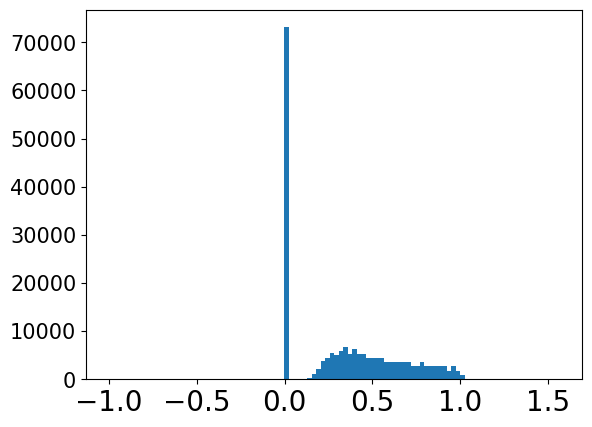

In [47]:
plt.hist(round1_return, bins=100)
plt.xticks(size = 20)
plt.yticks(size = 15)